# Table of contents
1. [Introduction](#introduction)
2. [Data load and presentation](#presentation)
3. [Shallow classifier](#shallow)
    1. [HoG features](#hog)
    2. [Fitting linear SVM](#svm)
4. [Transfer learning approach](#transfer)
5. [Visualize data with dimensionality reduction](#visualize)
    1. [PCA](#pca)
    2. [UMAP](#umap)
5. [Fitting linear SVM on top of CNN features](#svm_cnn)
6. [Fine tuning of CNN](#tuning)
7. [UMAP features for classification](#umap_features)
8. [Summary](#summary)

### Introduction <a name="introduction"></a>

CIFAR-10 data set is commonly used in machine learning tasks as a baseline for results of newly introduced algorithms[1]. It consists of 60,000 32x32 images with 10 label classes. It is balanced data set, with 6,000 representants of each class[2]. In case of this task there are 6 batches with 10,000 examples chosen randomly from uniform distribution. 5 of these batches are marked as training set and one of them as a test set. The goal of this assignment is to classify images from test set with algorithm trained on training set.

[1] https://www.kaggle.com/benhamner/popular-datasets-over-time/code
<br>
[2] https://www.cs.toronto.edu/~kriz/cifar.html

In [1]:
import os
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import seaborn as sns
from umap import UMAP
import pickle
import time
import xgboost as xgb
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

from ddrop import DropConnect
from utils import download, unpickle, load_cifar_data, data_generator, resize_images, timeit, hog_features, Timer
from visual_utils import plot_images, plot_pca_results, plot_umap_results

We will set custom figure size for all plots

In [2]:
plt.rcParams['figure.figsize'] = (10, 10)

### Data load and presentation <a name="presentation"></a>

Downloading dataset using custom function

In [ ]:
download()

Loading dataset

In [3]:
X_train, Y_train, X_val, Y_val, X_test, Y_test, label_names = load_cifar_data()

Checking the shape of loaded dataset

In [4]:
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)
print(X_test.shape)
print(Y_test.shape)

(40000, 32, 32, 3)
(40000,)
(10000, 32, 32, 3)
(10000,)
(10000, 32, 32, 3)
(10000,)


Plot images with one category for each row

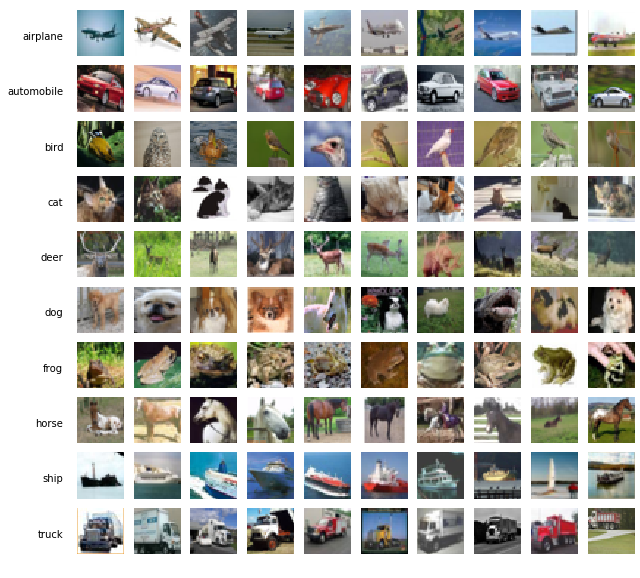

In [5]:
random.seed(42)
plot_images(X_train, Y_train, label_names)

### HoG features <a name='hog'></a>

Histogram of oriented gradients is a common method to extract features from images. The algorithm counts occurences of gradient orientation in a given part of an image. In this task we applied function to calculate HoG features, based on OpenCV implementation, which applies sobel mask on an image and then calculates histogram of gradient's orientations derived from processed input.

Create new variable to map labels to HoG features

In [6]:
hog_train = np.asarray([hog_features(array) for array in X_train])
hog_test = np.asarray([hog_features(array) for array in X_test])

### Fitting linear SVM on top of HoG features <a name='svm'></a>

Firstly we are going to use SVM with linear kernel to use it as our shallow classifier. Since we have 256 features extracted from histogram of gradients and 40,000 examples in training set we are going to use LinearSVC class from scikit-learn package, which is based on liblinear library and therefore scsales linearly with number of inputs and its features. Moreover, since it's just our base classifier, we are not going to use validation set.

In [7]:
@timeit
def linear_svm(X_train, Y_train, X_val, Y_val, c=1.0):
    clf = LinearSVC(C=c)
    clf.fit(X_train, Y_train)
    predictions_train = clf.predict(X_train)
    accuracy_train = accuracy_score(predictions_train, Y_train)
    predictions_val = clf.predict(X_val)
    accuracy_val = accuracy_score(predictions_val, Y_val)
    print(f"Accuracy on train: {accuracy_train} \n Accuracy on validation: {accuracy_val}")
    return accuracy_val, clf

In [8]:
linear_svm(hog_train, Y_train, hog_test, Y_test)

Accuracy on train: 0.55445 
 Accuracy on validation: 0.5345
Elapsed computation time: 9.821 secs


(0.5345, LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
      verbose=0))

The baseline accuracy for our algorithm is **0.5345** on test set. It is already much better than random guessing since
it would have given result of about 0.10 due to the fact that we have balanced data with 10 classes.

### Transfer learning approach <a name="transfer"></a>

We are going to move to transfer learning approach with pretrained on ImageNet dataset ResNet50, which can be found in Keras library, as our source of initial weights.
<br>
We chose Keras version 2.1.6 in order to lower number of features which are extracted after flattening the output from pretrained layers, since the AveragePooling layer in later versions of Keras changed its shape which results in much larger number of features extracted:
<br>
https://github.com/keras-team/keras/issues/10469
<br>
Transfer learning will consist of following parts:
* Extracting the features using ResNet50
* Visualize output using dimensionality reduction techniques (PCA and UMAP)
* Adding layers on top of pretrained neural network to add regularisation
* Playing with features extracted from UMAP to see if there is possibility to use another classifier (note that we shouldn't do something like that with t-SNE extracted features, which will be explained further)

In [9]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocessor
from tensorflow.keras.layers import Reshape, Dense, Dropout
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from sklearn.utils import shuffle

In [10]:
def resnet_base_flatten():
    model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224,3))
    out = Reshape((2048,))(model.out)
    return Model(model.input, out)

During data generation part we are going to transform images to fit ResNet architecture (with target shape being (224, 224, 3)).

In [ ]:
model = resnet_base_flatten()

batch_size = 40
codes_train = model.predict_generator(data_generator(X_train, Y_train, batch_size=batch_size), 
                                           X_train.shape[0]/batch_size, verbose=1)
codes_val = model.predict_generator(data_generator(X_val, Y_val, batch_size=batch_size), 
                                         X_val.shape[0] / batch_size, verbose=1)
codes_test = model.predict_generator(data_generator(X_test, Y_test, batch_size=batch_size), 
        X_test.shape[0]/ batch_size, verbose=1)

In [ ]:
np.save('codes_train.npy', codes_train) 
np.save('codes_val.npy', codes_val)
np.save('codes_test.npy', codes_test)

In [11]:
codes_train = np.load('saved_files/codes_train.npy')
codes_val = np.load('saved_files/codes_val.npy')
codes_test = np.load('saved_files/codes_test.npy')

### Visualize data with dimensionality reduction <a name="visualize"></a>

### PCA <a name='pca'></a>
We will take first two PCA components to visualize pretrained CNN codes.

In [12]:
pca = PCA(n_components=2)

components = pca.fit_transform(codes_train)

In [13]:
np.cumsum(pca.explained_variance_ratio_)

array([0.09281377, 0.146628  ], dtype=float32)

We can observe that first two components of PCA will explain small amount of variance in our data (lower than 15%), so we don't
expect the plot to be very informative

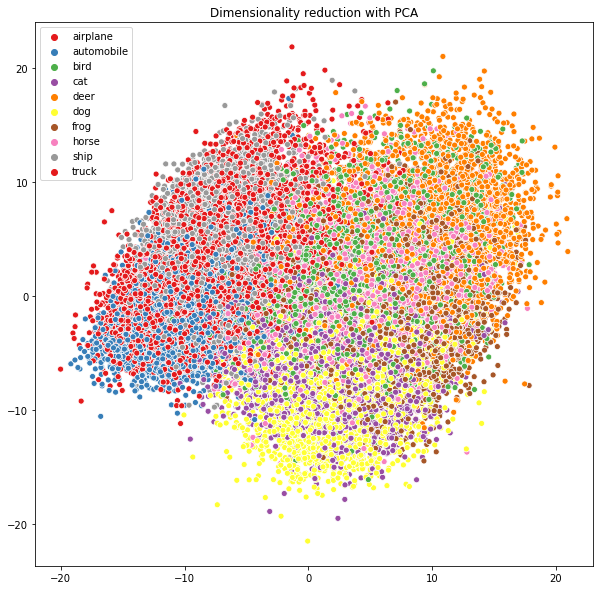

In [14]:
plot_pca_results(components, Y_train, label_names, "Dimensionality reduction with PCA")

However it is possible to observe first trend in our results - animals are closer to each other than trucks
and airplaines, so it can be seen that we can already have some meaningful interpretation of this visualisation.

### UMAP <a name='umap'></a>

UMAP is non-linear dimensionality reduction technique which has some advantages over commonly used t-SNE algorithm.
<br>
As written in original paper:
<br>
"(...) UMAP has significantly more stable results than t-SNE. In particular, after sub-sampling on 5% of
the million data points, the per point error for UMAP was already below any
value achieved by t-SNE."[1]
<br>
It has been already tested in many different cases, for example on biological data:
<br>
"(...) UMAP seems to yield representation that are
as meaningful as t-SNE does, particularly in its ability resolve even subtly differing cell
populations. In addition, it provides the useful and intuitively pleasing feature that it
preserves more of the global structure (...)"[2]

[1] https://arxiv.org/pdf/1802.03426.pdf
<br>
[2] https://www.biorxiv.org/content/biorxiv/early/2018/04/10/298430.full.pdf

In [15]:
neighbors = [100, 200, 300]

In [ ]:
with Timer():
    umaps = [UMAP(n_components=2, n_neighbors=number, random_state=42) for number in neighbors]
    umap_features = [umap.fit_transform(codes_train) for umap in umaps]

In [17]:
umap_features = pickle.load(open('saved_files/umap_features.pickle', 'rb'))

Plot result for different number of neighbors

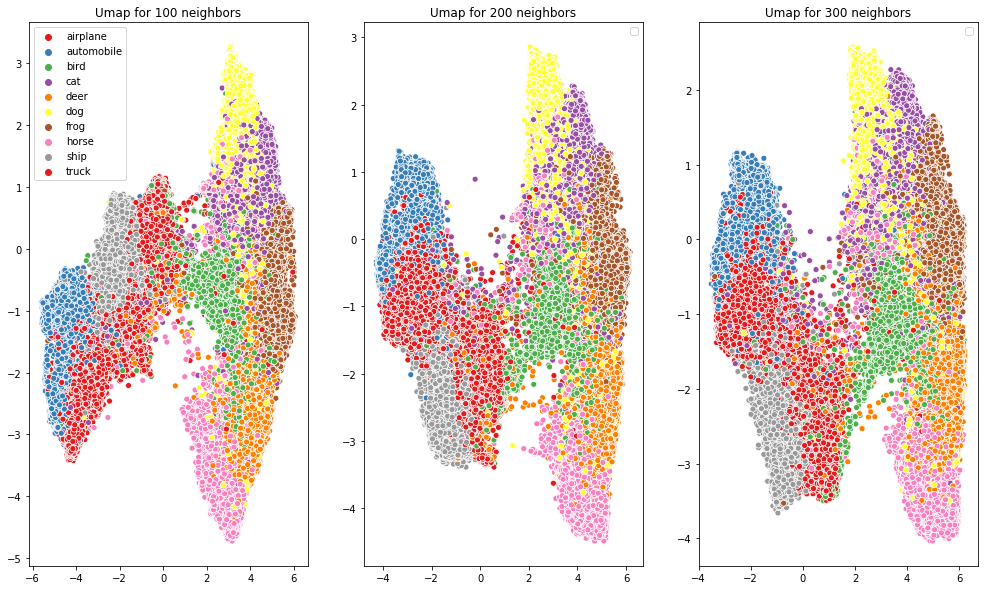

In [18]:
plot_umap_results(umap_features, neighbors, Y_train, label_names)

### Fitting linear SVM on top of CNN features <a name='svm_cnn'></a>

Grid search over parameter C (penalty parameter of the error term).

In [19]:
best = 0
best_model = None
for c in [1e-2, 1e-3, 5e-3, 1e-4]:
    print(f"Fitting for C value of {c}")
    result, model = linear_svm(codes_train, Y_train, codes_val, Y_val, c=c)
    if result > best:
        best = result
        best_model = model

Fitting for C value of 0.01
Accuracy on train: 0.970525 
 Accuracy on validation: 0.9111
Elapsed computation time: 77.013 secs
Fitting for C value of 0.001
Accuracy on train: 0.944775 
 Accuracy on validation: 0.9161
Elapsed computation time: 20.530 secs
Fitting for C value of 0.005
Accuracy on train: 0.96365 
 Accuracy on validation: 0.9137
Elapsed computation time: 50.822 secs
Fitting for C value of 0.0001
Accuracy on train: 0.9147 
 Accuracy on validation: 0.903
Elapsed computation time: 12.505 secs


In [20]:
accuracy_score(best_model.predict(codes_test), Y_test)

0.9145

Best obtained accuracy on validation was 0.9161 for C=0.001. Note that the smaller the value of C the higher the regularisation, as indicated in scikit-learn documentation. On test set we obtained **0.9145** accuracy, which is our benchmark for later approaches to the task.

Trying with non-linear version of kernel

In [21]:
@timeit
def svm_non_linear(X_train, Y_train, X_val, Y_val, C=1e-4, kernel='rbf'):
    clf = SVC(C, kernel=kernel, gamma='scale')
    clf.fit(X_train, Y_train)
    predictions_train = clf.predict(X_train)
    accuracy_train = accuracy_score(predictions_train, Y_train)
    predictions_val = clf.predict(X_val)
    accuracy_val = accuracy_score(predictions_val, Y_val)
    print(f"Accuracy on train: {accuracy_train} \n Accuracy on validation: {accuracy_val}")

In [ ]:
svm_non_linear(codes_train, Y_train, codes_val, Y_val)

The code did not compile until the end of the Colab session - we can either stick to linear svm and investigate different results with changed neural network or use dimensionality reduction and train more advenced classifier then.

### Fine tuning of CNN <a name='tuning'></a>

After extracting features from pretrained ResNet, we can add another layers on top of it to classify our images.
Our first approach will include adding dense layer with relu type activation and Dropout before it to regularize our network.

In [ ]:
def resnet_with_dropout(hidden_units=2048, drop_rate=0.5, input_shape=(2048, )):
    model = Sequential()
    model.add(Dropout(drop_rate, input_shape=input_shape))
    model.add(Dense(hidden_units, activation='relu', input_shape=input_shape))
    model.add(Dense(10, activation='softmax'))
    return model

In [ ]:
model_dropout = resnet_with_dropout()
model_dropout.compile(optimizer = Adam(lr=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
batch_size = 32
model_dropout.fit(codes_train, Y_train, batch_size=batch_size, epochs=100,
                  validation_data=(codes_val, Y_val),
                  callbacks=[ModelCheckpoint('dropout_05.h5', monitor='val_acc', save_best_only=True)])

There is also an alternative approach to regularize neural networks which is called DropConnect. DropConnect is a regularisation technique which was introduced as an alternative approach to dropout[1].
As written in a paper: "When training with Dropout,
a randomly selected subset of activations are
set to zero within each layer. DropConnect instead sets a randomly selected subset of weights within the network to zero." One can think of DropConnect as a Dropout generalization to the fully connected layers.

<figure class="image">
  <img src="figures/dropconnect.png" alt="dropconnect"></img>
  <figcaption><center> Comparison of neural network architectures taken from [2].</center></figcaption>
</figure>

[1] http://proceedings.mlr.press/v28/wan13.pdf
<br>
[2] https://cs.nyu.edu/~wanli/dropc/

In [ ]:
def resnet_with_dropconnect(hidden_units=2048, drop_rate=0.5, input_shape=(2048, )):
    model = Sequential()
    model.add(DropConnect(Dense(hidden_units, activation='relu'), prob=0.5,input_shape=input_shape))
    model.add(Dense(10, activation='softmax'))
    return model

In [ ]:
model_dropconnect = resnet_with_dropconnect()
model_dropconnect.compile(optimizer = Adam(lr=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
batch_size = 32
model_dropconnect.fit(codes_train, Y_train, batch_size=batch_size, epochs=100,
                  validation_data=(codes_val, Y_val),
                  callbacks=[ModelCheckpoint('dropconnect_05.h5', monitor='val_acc', save_best_only=True)])

Result of best model with dropout:

In [22]:
best_dropout = load_model('saved_files/dropout_05.h5')
best_dropout.evaluate(codes_test, Y_test)

10000/10000 [==============================] - 2s 169us/step


[0.44881426564455035, 0.9106]

Result of best model with dropconnect:

In [23]:
best_dropconnect = load_model('saved_files/dropconnect_05.h5', custom_objects={'DropConnect': DropConnect})
best_dropconnect.evaluate(codes_test, Y_test)

10000/10000 [==============================] - 2s 171us/step


[0.9892540756962291, 0.9167]

We achieved accuracy for neural network with DropConnect with **0.9167** for test set, which is our best result yet.

### Using UMAP features for classification <a name='umap_features'></a>

Another approach will be based on dimensionality reduction as used for data visualisation, but with larger number of components. It is worth to point out that t-SNE dimensionality reduction should not be used in such task as it minimizes the Kullback–Leibler divergence between the distribution defined on high dimensional features and low dimensional features, therefore it doesn't really learn any function to transform test set basing on training set.
<br>
We are going to use UMAP for this task as it can learn the transformation and apply it afterwards to test set. It is possible to do, as for example showed in official docs:
<br>
https://umap-learn.readthedocs.io/en/latest/transform.html
<br>
Number of neighbors used  was based on the fact that during training we encountered warning mentioned in this github issue:
<br>
https://github.com/lmcinnes/umap/issues/90
<br>
As a possible solution it is advised to change number of neighbors used to train to an order of magnitude of hundreds.

We are going to train UMAP on whole dataset with both train and validation at once.

In [24]:
codes_train_val = np.concatenate([codes_train, codes_val])
Y_train_val = np.concatenate([Y_train, Y_val])

In [ ]:
umap = UMAP(random_state=42, n_neighbors=100, n_components=50, verbose=True)
umap_50_features = umap.fit(codes_train_val)

In [ ]:
pickle.dump(umap_50_features, open("umap_50_features.pickle", 'wb'))

Fitting linear SVM on top of extracted features. We started with 50 components to have a benchmark for further trials.

In [ ]:
codes_umap_50_features = umap_50_features.transform(codes_train_val)
codes_umap_50_features_test = umap_50_features.transform(codes_test)

In [ ]:
np.save('saved_files/codes_umap_50_features.npy', codes_umap_50_features) 
np.save('saved_files/codes_umap_50_features_test.npy', codes_umap_50_features_test)

In [25]:
codes_umap_50_features = np.load('saved_files/codes_umap_50_features.npy')
codes_umap_50_features_test = np.load('saved_files/codes_umap_50_features_test.npy')

Fitting linear SVM

In [26]:
linear_svm(codes_umap_50_features, Y_train_val, codes_umap_50_features_test, Y_test, c=1e-3)

Accuracy on train: 0.78858 
 Accuracy on validation: 0.7617
Elapsed computation time: 1.325 secs


(0.7617, LinearSVC(C=0.001, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
      verbose=0))

Ok, so we lost about 15 percent points of accuracy - that is not very promising.

UMAP for several number of components has been fitted, however almost no change has been observed for number of components bigger than 50.

In [27]:
svm_non_linear(codes_umap_50_features, Y_train_val, codes_umap_50_features_test, Y_test)

Accuracy on train: 0.74726 
 Accuracy on validation: 0.7247
Elapsed computation time: 719.622 secs


Trying with xgboost

In [28]:
@timeit
def xgb_sk(model, X_train, Y_train, X_val, Y_val):
    clf = model
    clf.fit(X_train, Y_train)
    predictions_train = clf.predict(X_train)
    accuracy_train = accuracy_score(predictions_train, Y_train)
    predictions_val = clf.predict(X_val)
    accuracy_val = accuracy_score(predictions_val, Y_val)
    print(f"Accuracy on train: {accuracy_train} \n Accuracy on validation: {accuracy_val}")
    return accuracy_val

In [29]:
xgb_sk(xgb.XGBClassifier(), codes_umap_50_features, Y_train_val, codes_umap_50_features_test, Y_test)

Accuracy on train: 0.84948 
 Accuracy on validation: 0.8153
Elapsed computation time: 164.541 secs


0.8153

Ok, so it's not so bad - we can try some hyperparameter tuning then to see where we can go with this approach. We are going to use hyperopt package to optimize our parameters in Bayesian way.

In [ ]:
np.random.seed(42)
def objective(space):
    clf = xgb.XGBClassifier(n_estimators = 1000,colsample_bytree=space['colsample_bytree'],
                           learning_rate = .3,
                            max_depth = int(space['max_depth']),
                            min_child_weight = space['min_child_weight'],
                            subsample = space['subsample'],
                           gamma = space['gamma'],
                           reg_lambda = space['reg_lambda'],
                           tree_method = 'gpu_hist')

    eval_set  = [(codes_umap_50_features, Y_train_val), (codes_umap_50_features_test, Y_test)]

    clf.fit(codes_umap_50_features, Y_train_val,
            eval_set=eval_set, eval_metric="merror",
            early_stopping_rounds=10,verbose=False)

    pred = clf.predict(codes_umap_50_features_test)
    accuracy = accuracy_score(Y_test, pred)
    #change the metric if you like
    return {'loss':1-accuracy, 'status': STATUS_OK }


space ={'max_depth': hp.quniform("x_max_depth", 1, 13, 1),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.7, 1),
        'gamma' : hp.uniform ('x_gamma', 0.,0.5),
        'colsample_bytree' : hp.uniform ('x_colsample_bytree', 0.4,1),
        'reg_lambda' : hp.uniform ('x_reg_lambda', 0,1),
        'colsample_bylevel': hp.uniform('x_colsample_bylevel',0.4,1),
        'colsample_bynode' : hp.uniform('x_colsample_bynode',0.4,1),
        'reg_alpha': hp.uniform('x_reg_alpha',0,1)
        
    }


trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=1000,
            trials=trials)

In [ ]:
pickle.dump(best, open('saved_files/best.pickle', 'wb'))
pickle.dump(trials, open('saved_files/trials.pickle', 'wb'))

In [30]:
best = pickle.load(open('saved_files/best.pickle', 'rb'))
trials = pickle.load(open('saved_files/trials.pickle', 'rb'))

Changing two optimized parameters from float to required integer format and changing keys' names from hyperopt to automatically load them to the xgboost model.

In [31]:
for newkey, oldkey in zip(list(best.keys()), list(best.keys())):
    best[newkey[2:]] = best.pop(oldkey)
best['max_depth'] = int(best['max_depth'])
best['min_child'] = int(best['min_child'])

In [32]:
xgb_sk(xgb.XGBClassifier(**best), codes_umap_50_features, Y_train_val, codes_umap_50_features_test, Y_test)

Accuracy on train: 0.91646 
 Accuracy on validation: 0.8233
Elapsed computation time: 291.164 secs


0.8233

So after hyperparameter tuning not really much has changed and accuracy on test set yields now **0.8233**. Although it was worth a try :) Below one can find a visualisation of hyperparameters and their dependance on loss.

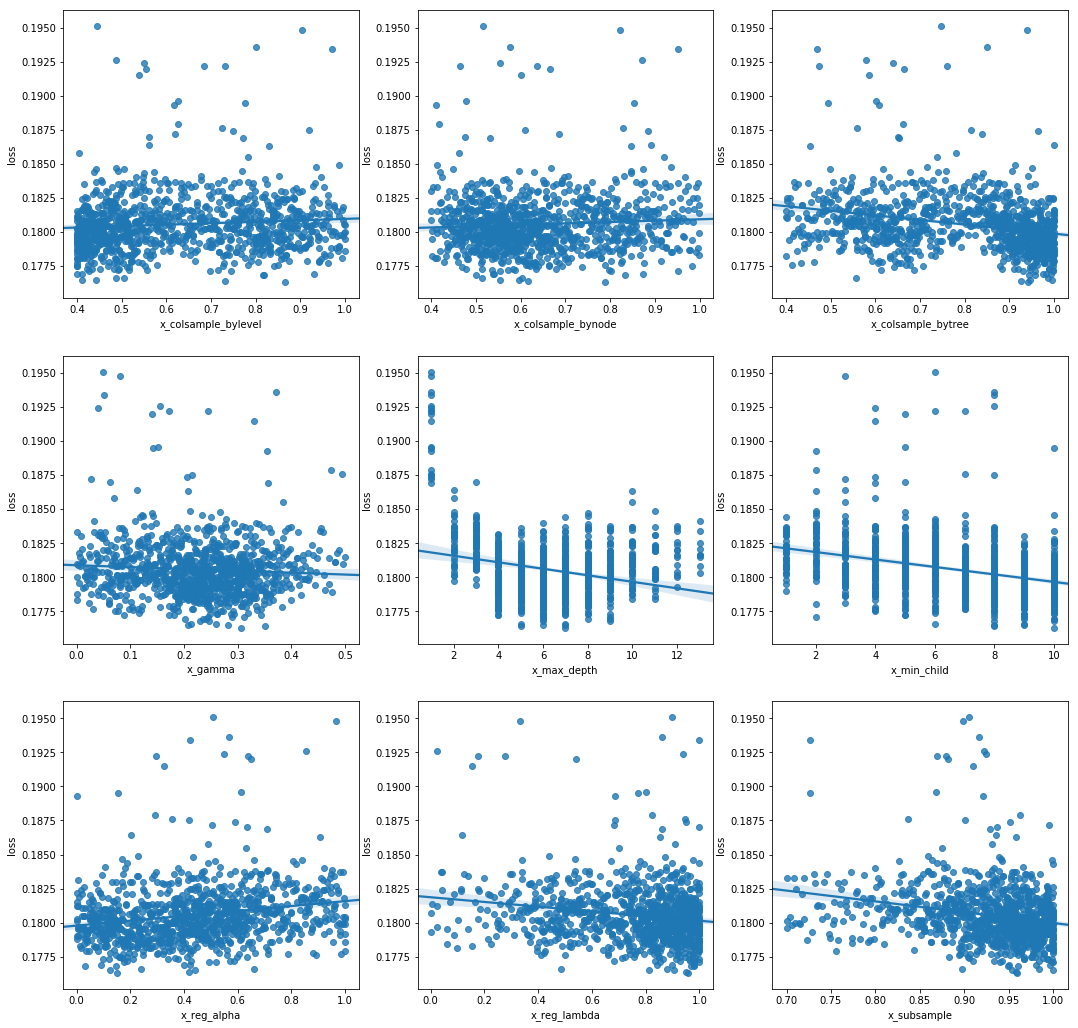

In [33]:
values = [key for key in list(trials)[0]['misc']['vals'].keys()]

loss_all = [x['result']['loss'] for x in list(trials)]
params_all = [[x['misc']['vals'][y][0] for x in list(trials)] for y in values]

params_hyperopt_df = pd.DataFrame([*params_all, loss_all]).T
params_hyperopt_df.columns = [*values, 'loss']

fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(18,18))
axes = axes.flatten()
plot_type = 'regplot'
for idx, ax in enumerate(axes):
    ax.ticklabel_format(style='sci')
    plt.sca(ax)
    try:
        getattr(sns, plot_type)(x=values[idx], y = 'loss', data=params_hyperopt_df)
        ax.ticklabel_format(style='scientific', scilimits=(-3,3))
    except AttributeError:
        print("Try different type of plot")
        raise AttributeError

### Summary <a name='summary'></a>

Several approaches to images classification of CIFAR-10 dataset have been investigated. Firstly we used HoG features extracted from images and obtained accuracy of 0.5345 after fitting linear SVM on them. Afterwards we used pretrained ResNet50 network to extract features from images and trained linear SVM on top of them, which resulted in accuracy of 0.9145 on test set. Then we moved to fine tuning of CNN and investigated two regularisation techniques: Dropout and DropConnect. In our case, the second one yielded better accuracy on test set of **0.9167** which was the best accuracy during performing this task. It shows that this alternative to Dropout may have useful applications.

We also tried to classify images based on features from dimensionality reduction. During this task it was discovered that it is unreasonable to do this with popular t-SNE dimensionality reduction technique, however UMAP provides such possibility, which was discussed in the notebook.

There were several things that left to be done in this work:
* Trying data augmentation of provided data set
* Freezing layers in ResNet
* Trying one of the things provided in the link to the task as state of the art: http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130